In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
df_pre = pd.read_csv("../data/drama_pre_stage.csv", encoding='cp932')

In [8]:
df_pre = df_pre[["drama_key" ,"pre_part", "part_count"]]


In [9]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [10]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""
df["pre_part"] = 0.0
df["part_count"] = 0

In [11]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
        
        if tmp_drama_key in df_pre.drama_key.values:
            df["pre_part"][tmp_index] = \
                df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0]
            df["part_count"][tmp_index] = \
                df_pre[df_pre["drama_key"] == tmp_drama_key]["part_count"].values[0]
#             float(df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0])
#         else:
#             print(tmp_drama_key)
    
    #         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [12]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [13]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [14]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [15]:
df_actress_pivot

,篠原涼子,小泉今日子,薬師丸ひろ子,江角マキコ,観月ありさ,菅野美穂,松下奈緒,波瑠,竹内結子,菜々緒,仲間由紀恵,広瀬アリス,天海祐希,広瀬すず,米倉涼子,高畑充希,剛力彩芽,黒木メイサ,芦田愛菜,柴崎コウ,柴咲コウ,優香,深津絵里,永作博美,真矢みき,木村佳乃,宮_あおい,山口智子,多部未華子,榮倉奈々,能年玲奈,藤原紀香,松雪泰子,松嶋菜々子,宮崎あおい,武井,上野樹里,木村文乃,松,上戸,吉高由里子,吉瀬美智子,松たか子,橋本環奈,小雪,堀北真希,北川景子,常盤貴子,吉永小百合,石原さとみ,土屋太鳳,上戸彩,杏,樹木希林,武井咲,長澤まさみ,井上真央,綾瀬はるか,深田恭子,石田ゆり子,吉田羊,黒木瞳,有村架純,佐々木希,蒼井優,新垣結衣,香里奈,戸田恵梨香,桐谷美玲
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,21,NaN,NaN,NaN,29,5,NaN,NaN,8,NaN,2,NaN,1,NaN,19,NaN,NaN,23,NaN,NaN,7,12,13,NaN,18,NaN,10,11,NaN,NaN,NaN,27,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,30,15,NaN,24,22,NaN,NaN,4,NaN,NaN,NaN,17,28,6,20,NaN,NaN,14,NaN,NaN,26,9,NaN,25,NaN
2011,12,16,NaN,NaN,24,1,23,NaN,13,NaN,5,NaN,6,NaN,26,NaN,NaN,7,NaN,NaN,4,NaN,11,29,20,NaN,9,28,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,14,15,NaN,22,21,NaN,3,NaN,NaN,NaN,NaN,27,2,17,NaN,NaN,30,NaN,NaN,25,10,NaN,NaN,NaN
2012,15,22,NaN,17,NaN,9,NaN,NaN,8,NaN,4,NaN,3,NaN,26,NaN,NaN,NaN,20,NaN,10,14,11,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,1,16,19,NaN,NaN,24,6,NaN,NaN,NaN,NaN,NaN,5,18,28,29,23,NaN,NaN,NaN,NaN,NaN,12,13,2,21,NaN,NaN,NaN,NaN,NaN,NaN,7,25,NaN,NaN
2013,10,21,29,15,NaN,6,NaN,NaN,25,NaN,7,NaN,3,NaN,11,NaN,30,NaN,NaN,NaN,8,12,16,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,24,NaN,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,2,14,23,27,19,NaN,4,NaN,18,26,17,20,1,13,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN
2014,14,11,28,20,26,6,29,NaN,NaN,NaN,10,NaN,9,NaN,13,NaN,NaN,NaN,NaN,NaN,7,16,27,NaN,NaN,NaN,30,NaN,NaN,NaN,25,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,2,4,NaN,19,8,NaN,3,15,24,21,22,17,1,18,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN
2015,13,24,NaN,NaN,NaN,15,NaN,NaN,16,NaN,3,NaN,8,NaN,9,NaN,NaN,NaN,NaN,NaN,6,19,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,14,NaN,NaN,30,NaN,NaN,NaN,26,27,11,NaN,NaN,2,4,NaN,25,12,NaN,10,7,NaN,23,22,20,1,18,NaN,NaN,NaN,NaN,21,NaN,5,NaN,NaN,29
2016,14,19,NaN,NaN,NaN,18,NaN,NaN,26,27,9,NaN,7,15,20,NaN,NaN,NaN,NaN,NaN,13,24,28,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,6,2,NaN,25,5,NaN,12,11,NaN,23,22,30,1,8,NaN,16,NaN,3,NaN,NaN,4,NaN,NaN,10
2017,10,27,NaN,NaN,NaN,17,NaN,NaN,29,NaN,7,NaN,8,11,18,NaN,NaN,NaN,NaN,13,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,24,26,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,15,4,NaN,NaN,3,19,12,14,NaN,23,16,28,2,5,20,NaN,NaN,6,30,NaN,1,NaN,NaN,9


In [16]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [18]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,篠原涼子,NaN,NaN,21,12,15,10,14,13,14,10,25,17
1,小泉今日子,NaN,NaN,NaN,16,22,21,11,24,19,27,NaN,NaN
2,薬師丸ひろ子,NaN,NaN,NaN,NaN,NaN,29,28,NaN,NaN,NaN,NaN,29
3,江角マキコ,NaN,NaN,NaN,NaN,17,15,20,NaN,NaN,NaN,NaN,NaN
4,観月ありさ,NaN,NaN,29,24,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN
5,菅野美穂,NaN,NaN,5,1,9,6,6,15,18,17,19,28
6,松下奈緒,NaN,NaN,NaN,23,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN
7,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25
8,竹内結子,NaN,NaN,8,13,8,25,NaN,16,26,29,NaN,21
9,菜々緒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN


In [19]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [20]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [21]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [22]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [23]:
df_actor_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,城島茂,NaN,NaN,NaN,NaN,NaN,NaN,29,18,18,NaN,NaN,NaN
1,伊東四朗,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,桐谷健太,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,15,NaN,NaN
3,江口洋介,NaN,NaN,26,17,29,26,NaN,NaN,NaN,NaN,NaN,NaN
4,遠藤憲一,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,18
5,香川照之,NaN,NaN,NaN,31,NaN,15,15,11,NaN,NaN,13,10
6,松本潤,NaN,NaN,10,6,8,6,4,8,10,20,23,5
7,渡辺謙,NaN,NaN,NaN,9,11,20,NaN,NaN,24,NaN,NaN,NaN
8,香取慎吾,NaN,NaN,2,5,10,4,9,10,15,24,18,NaN
9,斎藤工,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new8years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')]

In [26]:
df_new8years[ df_new8years.pre_part>0].drama_title.sort_values

<bound method Series.sort_values of 1          まだ結婚できない男
4              ドクターX
8         時効警察はじめました
10           おっさんずラブ
30             緊急取調室
34          家政夫のミタゾノ
42         家売るオンナの逆襲
63            下町ロケット
65              絶対零度
86          家政夫のミタゾノ
102             99.9
108            ドクターX
116      コード・ブルー 3rd
120             遺留捜査
134            緊急取調室
160            ドクターX
217            コウノドリ
225        花咲舞が黙ってない
258         DOCTORS3
272            MOZU2
273     ママとパパが生きる理由。
274            ドクターX
282             HERO
285              GTO
288           信長のシェフ
300        なるようになるさ。
306          刑事110キロ
307             MOZU
309      続・最後から二番目の恋
314        ファースト・クラス
319        チーム・バチスタ4
324              医龍4
337           リーガルハイ
339            ドクターX
344           都市伝説の女
350          救命病棟24時
353         ショムニ2013
355         DOCTORS2
359        警部補　矢部謙三2
360            斉藤さん2
364             ガリレオ
367             遺留捜査
380          ハンチョウ 6
415             遺留捜査
425          ハンチョウ 5
471             絶対零

In [27]:
df_new8years["main_actor1_rank"] = np.nan
df_new8years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new8years)):
    prev_year = df_new8years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new8years.loc[:,df_new8years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new8years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new8years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
# df_new8years["main_actor1_rank"]

In [30]:
# df_new8years["main_actor2_rank"]

In [31]:
df_episode = df_new8years.loc[:, df_new8years.columns.str.contains("Epi")]

In [32]:
df_new8years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new8years["average_calc"].iloc[i] = vr_sum/epi_i
            break
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new8years["average_calc"].iloc[i] = vr_sum / 15
        
    

### 視聴率を枠ごとに正規化する

In [34]:
norm_json = {}

for tmp_time in df_new8years.time_table:
    tmp_list = []
    for tmp_average in df_new8years [df_new8years["time_table"] == tmp_time].average:
        tmp_list.append(tmp_average)
#         print(len(tmp_average))
        
    
    norm_json[tmp_time] = sum(tmp_list)/ len(tmp_list)
    print(sum(tmp_list)/ len(tmp_list))
    print(len(tmp_list))
    
# pd.pivot_table(df_new8years.time_table)
# hoge

11.849714285714283
35
9.046739130434784
46
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
9.09090909090909
11
5.112631578947369
19
11.856938775510205
49
8.51578947368421
19
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
9.09090909090909
11
5.112631578947369
19
11.856938775510205
49
8.51578947368421
19
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
9.09090909090909
11
5.112631578947369
19
11.856938775510205
49
8.51578947368421
19
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6

11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
10.372083333333334
24
5.112631578947369
19
11.856938775510205
49
11.856938775510205
49
8.674285714285714
14
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
10.372083333333334
24
5.112631578947369
19
11.856938775510205
49
11.856938775510205
49
8.674285714285714
14
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
10.930851063829785
47
11.622115384615382
52
11.622115384615382
52
9.010857142857143
35
3.650857142857142
35
9.251999999999997
35
6.9791428571428575
35
10.372083333333334
24
5.112631578947369
19
11.856938775510205
49
11.856938775510205
49
8.674285714285714
14
11.849714285714283
35
9.490714285714287
28
9.046739130434784
46
11.1525
4
10.930851063829785
47
11.622115384615382
52
11.622115384615382
52

In [35]:
# norm_json

In [36]:
df_new8years["slot_vr_average"] = df_new8years["time_table"].apply(lambda tt : norm_json[tt]  )

In [37]:
df_new8years["pre_part_upfactor"] = 0

In [38]:

for i in range(len(df_new8years[df_new8years.pre_part > 0])):
    tmp_pre_part = df_new8years[df_new8years.pre_part > 0].iloc[i]["pre_part"]
    tmp_slot_vr_av = df_new8years[df_new8years.pre_part > 0].iloc[i]["slot_vr_average"]
    if tmp_pre_part > tmp_slot_vr_av:
        df_new8years["pre_part_upfactor"].iloc[i] = tmp_pre_part - tmp_slot_vr_av
    
    

In [39]:
df_new8years[df_new8years["pre_part_upfactor"]> 0]

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,pre_part,part_count,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,slot_vr_average,pre_part_upfactor
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,11.849714,7.853261
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,16.9,2.0,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,9.046739,9.277885
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,9.046739,5.020857
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,20.9,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,11.622115,2.277885
6,NTV,木23,CHEAT,4.2,3.0,4.4,3.0,3.1,2.9,3.5,3.7,3.5,3.2,-,-,-,-,-,3.45,4-5-0,2019-10-01,2019,10,1910_NTV_木23,本田翼,金子大地,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.450000,3.650857,0.669149
7,TBS,金22,4分間のマリーゴールド,10.3,7.8,7.6,6.2,7.1,5.7,7.1,6.4,7,9.2,-,-,-,-,-,7.52,4-5-0,2019-10-01,2019,10,1910_TBS_金22,福士蒼汰,菜々緒,キリエ「4分間のマリーゴールド」,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,菜々緒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,7.440000,9.252000,6.643061
8,EX,金23,時効警察はじめました,7.7,6.1,5.9,4.9,6.3,6.2,5.5,5.5,-,-,-,-,-,-,-,6.01,2001/5/1,2019-10-01,2019,10,1910_EX_金23,オダギリジョー,麻生久美子,,12.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.012500,6.979143,1.250286
9,NTV,土22,俺の話は長い,8.4,9.0,8.9,8.4,8,7.7,7.4,9.1,7.2,10.4,-,-,-,-,-,8.45,3-6-0,2019-10-01,2019,10,1910_NTV_土22,生田斗真,安田顕,,0.0,NaN,生田斗真,NaN,NaN,NaN,NaN,NaN,24,NaN,24,30,NaN,17,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.450000,9.090909,0.620857
10,EX,土23,おっさんずラブ,5.8,4.7,3.5,4.6,4.3,4.2,4.3,5.1,-,-,-,-,-,-,-,4.56,3-4-0,2019-10-01,2019,10,1910_EX_土23,田中圭,吉田鋼太郎,,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## CM数も特徴量に

In [40]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [41]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [42]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [43]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [44]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [45]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [46]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

# 特徴量エンジニアリング

### part3以降のものにフラグ

In [47]:
df_new8years["is_than_part3"] = 0
df_new8years["is_part2"] = 0

In [48]:
for tmp_idx in range(len(df_new8years)):
    
    if df_new8years["part_count"].iloc[tmp_idx] > 2:
        df_new8years["is_than_part3"].iloc[tmp_idx] = 1

    if df_new8years["part_count"].iloc[tmp_idx] == 2:
        df_new8years["is_part2"].iloc[tmp_idx] = 1
    

In [49]:
df_new8years["is_than_part3"]

0      0
1      0
2      0
3      0
4      1
      ..
493    0
494    0
495    0
496    0
497    0
Name: is_than_part3, Length: 498, dtype: int64

In [50]:
df_new8years[df_new8years["is_than_part3"] == True]

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,pre_part,part_count,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,slot_vr_average,pre_part_upfactor,is_than_part3,is_part2
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,20.9,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,11.622115,2.277885,1,0
8,EX,金23,時効警察はじめました,7.7,6.1,5.9,4.9,6.3,6.2,5.5,5.5,-,-,-,-,-,-,-,6.01,2001/5/1,2019-10-01,2019,10,1910_EX_金23,オダギリジョー,麻生久美子,,12.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.012500,6.979143,1.250286,1,0
30,EX,木21,緊急取調室,15.2,13.4,12.3,12.6,13.7,12.3,12.9,12.8,12.9,13.6,-,-,-,-,-,13.23,5-4-0,2019-04-01,2019,4,1904_EX_木21,天海祐希,田中哲司,,13.9,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,天海祐希,NaN,NaN,1,6,3,3,9,8,7,8,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.170000,11.622115,3.753261,1,0
34,EX,金23,家政夫のミタゾノ,8.2,6.5,7.5,7.4,5.9,5.6,5.7,6.4,-,-,-,-,-,-,-,6.65,3-4-0,2019-04-01,2019,4,1904_EX_金23,松岡昌宏,伊野尾慧,,6.7,3.0,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.650000,6.979143,2.720857,1,0
65,CX,月21,絶対零度,10.6,9.6,10.8,11.7,10.4,10.6,10.3,10,11.3,10.8,-,-,-,-,-,10.59,4-5-0,2018-07-01,2018,7,1807_CX_月21,沢村一樹,横山裕,,13.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.610000,11.849714,0.000000,1,0
108,EX,木21,ドクターX,20.9,19.6,19.0,19.1,20.8,20.7,20.1,20.6,21.2,25.3,-,-,-,-,-,20.87,5-4-0,2017-10-01,2017,10,1710_EX_木21,米倉涼子,永山絢斗,,21.5,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,20.730000,11.622115,0.000000,1,0
116,CX,月21,コード・ブルー 3rd,16.3,15.6,14.0,13.8,13.8,13.7,13.4,15.4,13.9,16.4,-,-,-,-,-,14.78,2002/6/1,2017-07-01,2017,7,1707_CX_月21,山下智久,新垣結衣,,16.6,3.0,山下智久,NaN,NaN,13,23,NaN,NaN,NaN,NaN,NaN,NaN,28,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,新垣結衣,NaN,NaN,9,10,7,9,5,5,4,1,2,2,13.0,9.0,14.630000,11.849714,0.000000,1,0
120,EX,木20,遺留捜査,13.1,8.8,10.9,10.8,10.1,10.8,10.3,11.2,10.6,-,-,-,-,-,-,10.97,3-5-0,2017-07-01,2017,7,1707_EX_木20,上川隆也,栗山千明,,11.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.733333,9.520000,0.000000,1,0
160,EX,木21,ドクターX,20.4,19.7,24.3,21.3,20.4,21.5,22.2,20.7,22.6,20.5,22.8,-,-,-,-,21.45,5-5-0,2016-10-01,2016,10,1610_EX_木21,米倉涼子,生瀬勝久,,22.9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Na

### 前の枠の数字

In [51]:
df_new8years["pre_slot_vr_average"] = np.nan

In [52]:
val_for_nan = sum(df_new8years.average)/len(df_new8years)

In [53]:
for tmp_idx in range(len(df_new8years)):
    if df_new8years["start_at_month"].iloc[tmp_idx] == 1:
        pre_slot_month = str(10) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx] - 1
    else:
        pre_slot_month = "0"+ str(int(df_new8years["start_at_month"].iloc[tmp_idx]) - 3) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx]
        
    time_table = df_new8years["time_table"].iloc[tmp_idx]
    TV_station = df_new8years["TV_station"].iloc[tmp_idx]
#     print(f"{pre_slot_year%2000}{pre_slot_month}_{time_table}_{TV_station} ")
    pre_key =  str(pre_slot_year%2000) + pre_slot_month+"_"+TV_station+"_"+time_table
    try:
        if pre_key in df["drama_key"].values:
            tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average) 
        else:
            tmp_pre_slot_vr_average = val_for_nan
#         print(pre_key)
    except:
        print(pre_key)
        tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average.values[0])
    
    print(tmp_pre_slot_vr_average)
    
    df_new8years["pre_slot_vr_average"].iloc[tmp_idx] = tmp_pre_slot_vr_average
#         float(df[df["drama_key"]==pre_key].average)

12.56
9.345783132530123
8.68
10.31
11.09
7.17
3.28
9.95
3.55
10.94
2.34
11.96
11.49
12.15
6.37
9.72
8.71
13.23
6.71
2.31
9.22
6.65
8.69
3.94
10.48
7.01
10.75
6.25
8.5
11.46
10.65
6.83
2.98
10.31
4.11
9.14
3.13
9.77
11.47
10.81
6.58
6.92
8.75
15.74
6.71
3.33
10.11
5.25
8.83
3.59
13.61
9.87
10.59
5.8
14.15
9.49
10.41
11.24
3.16
7.14
4.51
8.87
3.91
9.77
6.62
8.88
7.79
8.3
9.77
13.02
6.23
3.03
8.46
6.73
8.24
3.99
14.29
7.45
6.14
6.93
7.74
6.16
15.24
6.26
3.09
11.14
5.19
9.82
3.47
17.63
6.95
6.74
5.75
7.73
12.65
20.87
6.53
3.48
11.87
4.83
8.77
9.345783132530123
16.0
6.19
14.78
6.07
10.17
11.47
11.45
4.5
3.45
7.33
4.0
8.7
9.73
8.58
8.77
10.58
11.25
9.17
9.345783132530123
14.09
6.44
3.33
8.79
5.45
9.55
13.6
5.35
7.68
6.65
11.3
8.9
11.39
9.74
6.53
3.42
8.32
6.46
9.345783132530123
14.55
4.99
9.3
8.23
8.13
14.58
12.37
21.45
7.05
3.53
10.18
7.66
8.31
7.18
10.66
7.17
8.92
9.345783132530123
7.92
11.59
9.86
7.1
2.93
5.62
5.64
6.66
6.13
10.58
8.27
8.54
8.18
8.02
12.88
10.77
5.61
3.47
9.03
7.7
7.91
4.

In [54]:
df_new8years = df_new8years.fillna({'part_count': 0})

### 俳優ランクを人気ポイントに

In [55]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_rank"].apply(lambda x : (41 - x)/40 )

In [56]:
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_rank"].apply(lambda x : (41 - x)/40 )

In [57]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_pt"].fillna(0)
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_pt"].fillna(0)

In [58]:
df_new8years["has_original_work"] = df_new8years["original_work"].apply(lambda x : 0 if x =="" else 1 ) 

### 年を特徴量エンジニアリング

In [59]:
df_new8years["year_feature"] =  df_new8years["start_at_year"] - 2010

### (TODO) CM数も特徴量に加工する

### one hotエンコーディング

In [60]:
# df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month", "start_at_year","time_table"] )
df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month","time_table"] )
df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month","time_table"] )

## wikiの俳優情報を特徴量として

In [61]:
f = open("../data/actor_wiki0220.json", 'r')
print(f)
actor_wiki_json = json.load(f)
df_actor_wiki = pd.read_excel("../data/wiki_raw.xlsx" )



<_io.TextIOWrapper name='../data/actor_wiki0220.json' mode='r' encoding='UTF-8'>


In [62]:
# df_new8years["time_table"]
df_new8years["pre_part_upfactor"]

# hoge



0      7.853261
1      9.277885
2      5.020857
3      0.000000
4      2.277885
         ...   
493    0.000000
494    0.000000
495    0.000000
496    0.000000
497    0.000000
Name: pre_part_upfactor, Length: 498, dtype: float64

In [63]:
df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"]["office"] = "ジャニーズ事務所"

In [64]:
target_idx = df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"].index.values

In [65]:
df_actor_wiki["office"].iloc[target_idx] = "ジャニーズ事務所"

In [66]:
df_actor_wiki.iloc[target_idx]["office"]

18    ジャニーズ事務所
Name: office, dtype: object

In [67]:
# Jかどうか
df_actor_wiki["isj"] = df_actor_wiki["office"] == "ジャニーズ事務所"

In [68]:
# df_new8years["actor1_office"] = np.nan
# df_new8years["actor2_office"] = np.nan
# df_new8years["actor1_birthday"] = np.nan
# df_new8years["actor2_birthday"] = np.nan
df_new8years["actor1_isj"] = 0
df_new8years["actor2_isj"] = 0

In [69]:
for idx in range(len(df_new8years)):
    actor1 = df_new8years["main_actor1"].iloc[idx]
    actor2 = df_new8years["main_actor2"].iloc[idx]
    
    if actor1 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor1_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor1].isj.values[0])
    
    if actor2 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor2_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor2].isj.values[0])
        

In [70]:
# df_new8years[df_new8years["actor1_isj"]==True]

In [71]:
# for idx in range(len(df_new8years)):
#     actor1 = df_new8years["main_actor1"].iloc[idx]
#     actor2 = df_new8years["main_actor2"].iloc[idx]
# #     print(actor1)
    
#     if actor_wiki_json[actor1]:
    
#         df_new8years["actor1_office"].iloc[idx] = actor_wiki_json[actor1].get("office")
#         df_new8years["actor1_birthday"].iloc[idx] = actor_wiki_json[actor1].get("birthday")
    
#     if actor_wiki_json[actor2]:
#         df_new8years["actor2_office"].iloc[idx] = actor_wiki_json[actor2].get("office")
#         df_new8years["actor2_birthday"].iloc[idx] = actor_wiki_json[actor2].get("birthday")

### dummy化

In [72]:
X = df_new8years[["main_actor1_pt" , "main_actor2_pt", "actor1_isj","actor2_isj", \
                  "has_original_work",\
                  "is_than_part3","is_part2",\
                  "year_feature"]]

In [73]:
# X_dummys = df_new8years.loc[:,df_new8years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|time_table'))]
X_dummys = df_new8years.loc[:,df_new8years.columns.str.contains(('start_at_year_|start_at_month_|time_table'))]

In [74]:
X_dummys

,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,time_table_土21,time_table_土22,time_table_土23,time_table_日21,time_table_日22,time_table_日23,time_table_月20,time_table_月21,time_table_木20,time_table_木21,time_table_木22,time_table_木23,time_table_水21,time_table_水22,time_table_火21,time_table_火22,time_table_金20,time_table_金22,time_table_金23
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
494,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
495,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
496,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
X = pd.concat([X,X_dummys], axis=1)


#### モデル作成

In [76]:
y = df_new8years["average"]

In [77]:
lm = LinearRegression()

In [78]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12345 )

In [79]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [80]:
y_pred = lm.predict(X_test)

In [81]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [82]:
print(lm_rmse)

2.4957441848897868


In [83]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.9920973802047 
嫌われる勇気	 視聴率：実際 6.53   	 予測 6.948891474004161 
ラヴソング	 視聴率：実際 8.54   	 予測 10.518480670154108 
お義父さんと呼ばせて	 視聴率：実際 6.94   	 予測 8.09258937701599 
SUITS	 視聴率：実際 10.81   	 予測 9.22402126200463 
イノセンス	 視聴率：実際 9.14   	 予測 8.357996286598798 
VISION	 視聴率：実際 3.02   	 予測 4.409133525551289 
恋愛ニート	 視聴率：実際 9.14   	 予測 11.409755465549235 
失恋保険 告らせ屋	 視聴率：実際 3.82   	 予測 4.987796322615866 
あなたには帰る家がある	 視聴率：実際 8.46   	 予測 8.774931202312246 
謎解きはディナーのあとで	 視聴率：実際 15.93   	 予測 12.002384760160073 
チーム・バチスタ3	 視聴率：実際 12.85   	 予測 13.359897519949122 
健康で文化的な最低限度の生活	 視聴率：実際 5.8   	 予測 7.545952207416798 
青春探偵ハルヤ	 視聴率：実際 4.32   	 予測 4.035739847404263 
パーフェクトワールド	 視聴率：実際 6.37   	 予測 7.473085640967033 
HEAT	 視聴率：実際 4.12   	 予測 8.10476381803394 
浪花少年探偵団	 視聴率：実際 6.13   	 予測 7.828585171281686 
心がポキッとね	 視聴率：実際 6.71   	 予測 10.210747871302802 
おっさんずラブ	 視聴率：実際 4.56   	 予測 5.6276514141027825 
A LIFE	 視聴率：実際 14.55   	 予測 13.467152591446498 
わたし、定時で帰ります。	 視聴率：実際 9.72   	 予測 7.

In [84]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    d = df_new8years.iloc[y_test.index[i]].main_actor1_pt
    e = df_new8years.iloc[y_test.index[i]].main_actor2_pt
    f = df_new8years.iloc[y_test.index[i]].pre_part
    g = df_new8years.iloc[y_test.index[i]].pre_slot_vr_average
    if abs (a-b) > 3:
        print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ,{d} ,{e},{f}, {g}')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.9920973802047 ,0.875 ,0.0,0.0, 11.32
謎解きはディナーのあとで	 視聴率：実際 15.93   	 予測 12.002384760160073 ,1.0 ,0.0,0.0, 13.13
HEAT	 視聴率：実際 4.12   	 予測 8.10476381803394 ,0.0 ,0.0,0.0, 4.78
心がポキッとね	 視聴率：実際 6.71   	 予測 10.210747871302802 ,0.0 ,0.0,0.0, 7.68
グッド・ドクター	 視聴率：実際 11.24   	 予測 6.998772017931314 ,0.0 ,0.0,0.0, 6.23
昼顔	 視聴率：実際 13.9   	 予測 9.753214780676617 ,0.925 ,0.0,0.0, 12.86
お天気お姉さん	 視聴率：実際 9.84   	 予測 6.192135487807285 ,0.0 ,0.0,0.0, 10.84
PRICELESS	 視聴率：実際 17.71   	 予測 13.623925684716493 ,0.925 ,0.0,0.0, 12.4
リーガルV	 視聴率：実際 15.74   	 予測 9.861336720129998 ,0.55 ,0.0,0.0, 10.41
夫のカノジョ	 視聴率：実際 3.87   	 予測 10.642752981209089 ,0.0 ,0.0,0.0, 7.5
ドクターX	 視聴率：実際 22.98   	 予測 13.515887467671806 ,0.55 ,0.0,19.1, 18.32
JIN -仁-	 視聴率：実際 21.28   	 予測 15.726734002219857 ,0.0 ,0.875,19.2, 13.98
東京バンドワゴン	 視聴率：実際 7.12   	 予測 10.576438544949708 ,0.0 ,0.0,0.0, 12.4
ハングリー！	 視聴率：実際 12.68   	 予測 9.395648104044675 ,0.0 ,0.0,0.0, 10.99
貴族探偵	 視聴率：実際 8.77   	 予測 12.065913222758244 ,

In [85]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	1.6106050346929344 
1  回帰係数 main_actor2_pt	1.920779453029724 
2  回帰係数 actor1_isj	0.30469683002867126 
3  回帰係数 actor2_isj	-0.6892354664235457 
4  回帰係数 has_original_work	0.038425621374347206 
5  回帰係数 is_than_part3	3.913649353512152 
6  回帰係数 is_part2	2.0257273387559507 
7  回帰係数 year_feature	-0.32576468175717127 
8  回帰係数 start_at_month_1	0.10677367279728953 
9  回帰係数 start_at_month_4	0.0460815473654734 
10  回帰係数 start_at_month_7	-0.2068165679419323 
11  回帰係数 start_at_month_10	0.05396134777953649 
12  回帰係数 time_table_土21	1.5101148773915751 
13  回帰係数 time_table_土22	1.5365708359689583 
14  回帰係数 time_table_土23	-3.166689050265255 
15  回帰係数 time_table_日21	2.615048241433157 
16  回帰係数 time_table_日22	1.577794864694798 
17  回帰係数 time_table_日23	-3.323603628998623 
18  回帰係数 time_table_月20	-0.9980284322834782 
19  回帰係数 time_table_月21	2.780453299684571 
20  回帰係数 time_table_木20	-0.6572819560583637 
21  回帰係数 time_table_木21	1.8811261436796263 
22  回帰係数 time_table_木22	0.126746504909176

In [86]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 9.647


In [87]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.5442124442898651


In [88]:
# lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print (f"rmse: {lm_rmse}")

# モデル２決定木

In [89]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 16)
# clf = DecisionTreeRegressor(max_leaf_nodes= 12)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=16, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [90]:
y_pred_tree = clf.predict(X_test)

In [91]:
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (rf_rmse)

3.137637570800216


In [92]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.24163157244684513 
1  FI main_actor2_pt     	0.1233471195658675 
2  FI actor1_isj     	0.0 
3  FI actor2_isj     	0.0 
4  FI has_original_work     	0.0 
5  FI is_than_part3     	0.0 
6  FI is_part2     	0.04381113944431952 
7  FI year_feature     	0.11616708987404371 
8  FI start_at_month_1     	0.0 
9  FI start_at_month_4     	0.0 
10  FI start_at_month_7     	0.0 
11  FI start_at_month_10     	0.0 
12  FI time_table_土21     	0.0 
13  FI time_table_土22     	0.0 
14  FI time_table_土23     	0.07357039499896847 
15  FI time_table_日21     	0.03154405075942753 
16  FI time_table_日22     	0.0 
17  FI time_table_日23     	0.017854628993647592 
18  FI time_table_月20     	0.0 
19  FI time_table_月21     	0.02569489251780369 
20  FI time_table_木20     	0.0 
21  FI time_table_木21     	0.0 
22  FI time_table_木22     	0.0 
23  FI time_table_木23     	0.2419070237404905 
24  FI time_table_水21     	0.0 
25  FI time_table_水22     	0.03765327625605958 
26  FI time_table_火21   

In [93]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 16.01   	 予測 11.9920973802047 
視聴率：実際 6.53   	 予測 6.948891474004161 
視聴率：実際 8.54   	 予測 10.518480670154108 
視聴率：実際 6.94   	 予測 8.09258937701599 
視聴率：実際 10.81   	 予測 9.22402126200463 
視聴率：実際 9.14   	 予測 8.357996286598798 
視聴率：実際 3.02   	 予測 4.409133525551289 
視聴率：実際 9.14   	 予測 11.409755465549235 
視聴率：実際 3.82   	 予測 4.987796322615866 
視聴率：実際 8.46   	 予測 8.774931202312246 
視聴率：実際 15.93   	 予測 12.002384760160073 
視聴率：実際 12.85   	 予測 13.359897519949122 
視聴率：実際 5.8   	 予測 7.545952207416798 
視聴率：実際 4.32   	 予測 4.035739847404263 
視聴率：実際 6.37   	 予測 7.473085640967033 
視聴率：実際 4.12   	 予測 8.10476381803394 
視聴率：実際 6.13   	 予測 7.828585171281686 
視聴率：実際 6.71   	 予測 10.210747871302802 
視聴率：実際 4.56   	 予測 5.6276514141027825 
視聴率：実際 14.55   	 予測 13.467152591446498 
視聴率：実際 9.72   	 予測 7.093028827687007 
視聴率：実際 11.24   	 予測 6.998772017931314 
視聴率：実際 12.86   	 予測 11.941980037788257 
視聴率：実際 7.5   	 予測 9.997436429092744 
視聴率：実際 3.09   	 予測 2.8065612971218306 
視聴率：実際 13.9   	 予測 9.753214780676617 
視聴

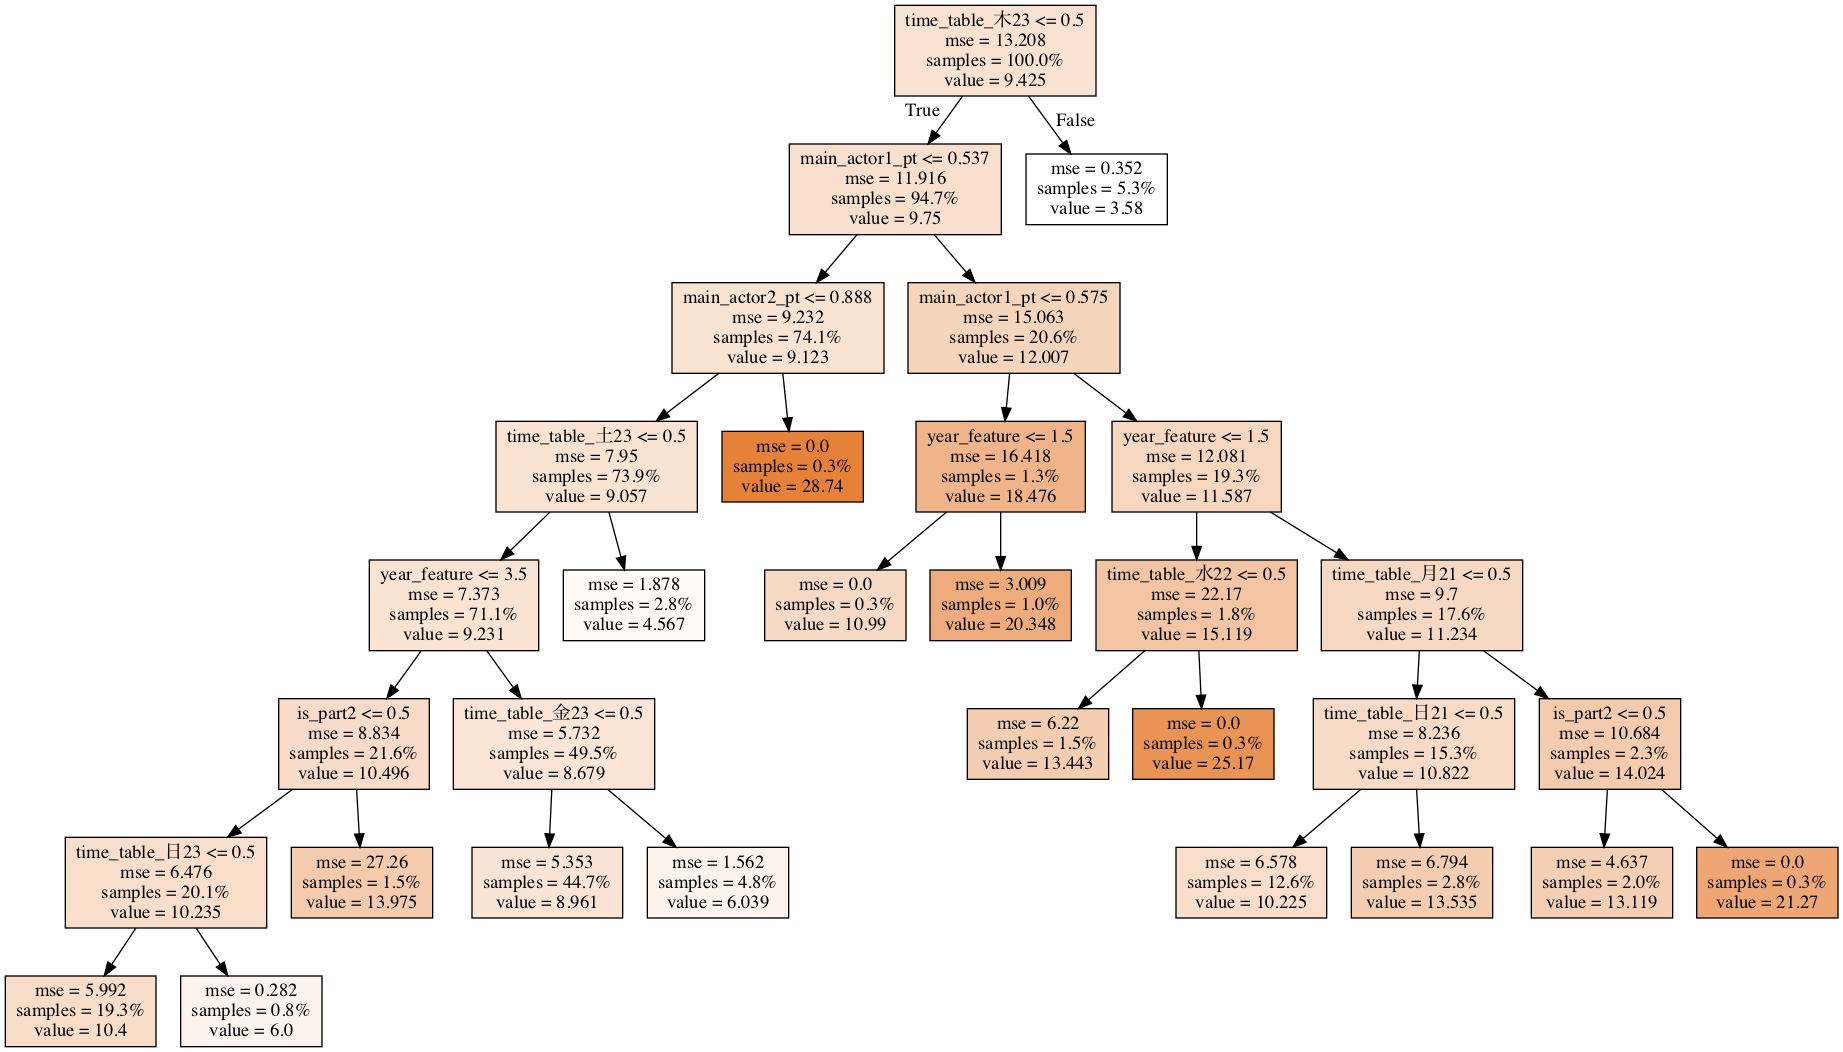

In [94]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### モデル３　線形回帰 目的変数を初回に

In [95]:
y1 = df_new8years["Episode1"]

In [96]:
lm1 = LinearRegression()

In [97]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y1,test_size=0.2,random_state=12345 )

In [98]:
model1 = lm1.fit(X_train1,y_train1)
#predictions=model.predict(x_test)

In [99]:
y_pred1 = lm1.predict(X_test1)

In [100]:
lm1_rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))

In [101]:
print(lm1_rmse)

2.2572472847992793


In [102]:
for i in range(len(y_pred1)):
    a = y_test1.values[i]
    b = y_pred1[i]
    c = df_new8years.iloc[y_test1.index[i]].drama_title
    print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 14.3   	 予測 13.476066129552475 
嫌われる勇気	 視聴率：実際 8.1   	 予測 7.653414148161495 
ラヴソング	 視聴率：実際 10.6   	 予測 12.027264069476185 
お義父さんと呼ばせて	 視聴率：実際 9.6   	 予測 9.079349034669324 
SUITS	 視聴率：実際 14.2   	 予測 10.596692759524693 
イノセンス	 視聴率：実際 8.3   	 予測 10.107189015438522 
VISION	 視聴率：実際 4.1   	 予測 5.519943815455032 
恋愛ニート	 視聴率：実際 11.9   	 予測 13.106516756596815 
失恋保険 告らせ屋	 視聴率：実際 7.3   	 予測 5.85255271051524 
あなたには帰る家がある	 視聴率：実際 9.3   	 予測 10.18670664135691 
謎解きはディナーのあとで	 視聴率：実際 18.1   	 予測 14.545377500313382 
チーム・バチスタ3	 視聴率：実際 14.2   	 予測 15.429313393766424 
健康で文化的な最低限度の生活	 視聴率：実際 7.6   	 予測 9.463649827302799 
青春探偵ハルヤ	 視聴率：実際 5.1   	 予測 5.06586889322319 
パーフェクトワールド	 視聴率：実際 6.9   	 予測 8.92981772182372 
HEAT	 視聴率：実際 6.6   	 予測 9.375389450509577 
浪花少年探偵団	 視聴率：実際 7.8   	 予測 9.404625835534329 
心がポキッとね	 視聴率：実際 10.4   	 予測 11.246183048654085 
おっさんずラブ	 視聴率：実際 5.8   	 予測 6.151608505368555 
A LIFE	 視聴率：実際 14.2   	 予測 14.531041305803248 
わたし、定時で帰ります。	 視聴率：実際 9.5   	 予測 7.84764269005540

In [103]:
for i in range(len(y_pred1)):
    a = y_test1.values[i]
    b = y_pred1[i]
    c = df_new8years.iloc[y_test1.index[i]].drama_title
    if abs (a-b) > 3:
        print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

SUITS	 視聴率：実際 14.2   	 予測 10.596692759524693 
謎解きはディナーのあとで	 視聴率：実際 18.1   	 予測 14.545377500313382 
グッド・ドクター	 視聴率：実際 11.5   	 予測 8.12313006992106 
お天気お姉さん	 視聴率：実際 11.9   	 予測 6.868102855206282 
リーガルV	 視聴率：実際 15.0   	 予測 10.687891946633295 
夫のカノジョ	 視聴率：実際 4.7   	 予測 12.32960185270643 
ドクターX	 視聴率：実際 22.8   	 予測 14.853446882960856 
dinner	 視聴率：実際 8.8   	 予測 13.08227912109024 
JIN -仁-	 視聴率：実際 23.7   	 予測 17.445434049259593 
緊急取調室	 視聴率：実際 17.9   	 予測 13.62953052794066 
東京バンドワゴン	 視聴率：実際 8.8   	 予測 13.401162433962064 
ハングリー！	 視聴率：実際 14.2   	 予測 10.812231035747892 
ファーストクラス	 視聴率：実際 8.8   	 予測 11.849642900136283 
ドクターX	 視聴率：実際 20.4   	 予測 15.569628043517023 
下町ロケット	 視聴率：実際 16.1   	 予測 13.020036792350961 
アリスの棘	 視聴率：実際 14.2   	 予測 10.530673238998366 


In [104]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model1.coef_[i]} """)

0  回帰係数 main_actor1_pt	1.5093444383798376 
1  回帰係数 main_actor2_pt	2.280354858112167 
2  回帰係数 actor1_isj	0.47021198674012843 
3  回帰係数 actor2_isj	-1.0401165064585973 
4  回帰係数 has_original_work	0.3057468458338341 
5  回帰係数 is_than_part3	4.015295096344444 
6  回帰係数 is_part2	1.9994524349793508 
7  回帰係数 year_feature	-0.43322050026964226 
8  回帰係数 start_at_month_1	0.11063102812370244 
9  回帰係数 start_at_month_4	-0.12716066151512087 
10  回帰係数 start_at_month_7	-0.02654905630568618 
11  回帰係数 start_at_month_10	0.043078689697435536 
12  回帰係数 time_table_土21	2.383908339706283 
13  回帰係数 time_table_土22	2.39766441694829 
14  回帰係数 time_table_土23	-3.4898161896747593 
15  回帰係数 time_table_日21	2.207427356589716 
16  回帰係数 time_table_日22	1.6215347202153985 
17  回帰係数 time_table_日23	-4.3668607423163746 
18  回帰係数 time_table_月20	-1.5060090262478427 
19  回帰係数 time_table_月21	3.2558696598158505 
20  回帰係数 time_table_木20	-0.01907066238879765 
21  回帰係数 time_table_木21	1.7825597451907778 
22  回帰係数 time_table_木22	-0.1881817902

In [105]:
print('モデル関数の切片 w2: %.3f' %model1.intercept_)

モデル関数の切片 w2: 11.498


In [106]:
print('決定係数 R^2： ', model1.score(X, y1))

決定係数 R^2：  0.617467856062025


In [107]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

np.random.seed(9876789)

In [108]:
# Fit and summary:

# Fit and summary:

model_sm = sm.OLS(y, sm.add_constant(X))
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                average   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     19.63
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           2.60e-63
Time:                        16:26:25   Log-Likelihood:                -1168.0
No. Observations:                 498   AIC:                             2396.
Df Residuals:                     468   BIC:                             2522.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3174      0.25

In [109]:
len(res.predict())

498

In [110]:
res.predict()[y_test.index]

array([12.30319648,  7.03529681, 10.36268205,  8.07028946,  9.23643475,
        8.4895136 ,  4.27870563, 11.63966865,  4.92786445,  8.68859798,
       12.20629324, 13.54688522,  7.40482099,  3.9114181 ,  7.41797477,
        8.03530867,  7.51444089, 10.07207315,  6.23561065, 13.68834427,
        7.14669938,  6.98181737, 12.49354454,  9.98062241,  2.77591831,
       10.08948859,  9.27374539,  6.3805132 ,  3.46511597,  9.02897444,
        5.30810328,  7.13309724,  8.78690929,  9.01109886,  5.95726209,
       13.72591701,  4.64895265,  7.54175404, 11.51374807, 10.35628649,
       10.8760051 , 12.54251828,  8.2790275 , 14.42789016,  7.93582493,
       10.82586847, 12.79507447,  8.04846245, 12.85482079,  8.93581573,
       12.11773248, 16.18863443,  9.98412969,  5.29083957,  5.89883336,
        8.35071878,  3.35967886,  6.36201453, 14.32188492,  3.09486895,
       13.99930103, 10.29541154,  6.09625651,  8.70246713,  3.70809886,
       11.74225787,  7.43980178, 10.41190268,  5.48207848,  4.68

In [111]:
def rmse_accuracy_percentage(actual,predicted): 
    a = actual
    b = predicted
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))

In [112]:
rmse_accuracy_percentage( y_test, res.predict()[y_test.index])

RMSE is: 2.38


In [113]:
model_sm1 = sm.OLS(y1, sm.add_constant(X))
res1 = model_sm1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:               Episode1   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     26.42
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           2.97e-80
Time:                        16:26:25   Log-Likelihood:                -1137.4
No. Observations:                 498   AIC:                             2335.
Df Residuals:                     468   BIC:                             2461.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.7655      0.24

In [114]:
rmse_accuracy_percentage( y_test, res1.predict()[y_test.index])

RMSE is: 2.75
